In [1]:
import os
import pandas as pd
import numpy as np

from math import nan
from future.utils import iteritems

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = "darkgrid")


import keras as k
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

TensorFlow 1.x selected.
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-3a21lik0
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-3a21lik0
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=4e7f183a20cded8eedbff73b0bfa677fe2dc76e4d4b5643b32db304b29d401be
  Stored in directory: /tmp/pip-ephem-wheel-cache-exuc74fy/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
     |████████████████████████████████| 747kB 7.6MB/s 
     |████████████████████████████████| 51kB 3.4MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=f650255a548b07cfe908f5a9db6b76df34168d01f38378bcec024359f8541fd8
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [3]:
cd gdrive/MyDrive/coursework

/content/gdrive/MyDrive/coursework


In [4]:
from scienceie_loader import load_tokenized_data, load_data_with_char_offsets, get_entity_span_from_B_index

In [5]:
data_root = os.path.join(os.getcwd(), 'original_datasets')
data_train = os.path.join(data_root, 'scienceie2017_train/train2')
data_dev = os.path.join(data_root, 'scienceie2017_dev/dev')
data_test = os.path.join(data_root, 'semeval_articles_test')

In [6]:
train_docs, train_rels, _ = load_tokenized_data(data_train)
dev_docs, dev_rels, _ = load_tokenized_data(data_dev)
test_docs, test_rels, _ = load_tokenized_data(data_test)

In [7]:
train_docs_chars = load_data_with_char_offsets(data_train)
test_docs_chars = load_data_with_char_offsets(data_test)
dev_docs_chars = load_data_with_char_offsets(data_dev)

In [8]:
train = [j for i in train_docs for j in i]
test = [j for i in test_docs for j in i]
dev = [j for i in dev_docs for j in i]

In [9]:
train_dataset = pd.DataFrame(train, columns = ["Words", "Tags"])
test_dataset = pd.DataFrame(test, columns = ["Words", "Tags"])
dev_dataset = pd.DataFrame(dev, columns = ["Words", "Tags"])

In [10]:
r = []
for i in range(len(train_docs)):
  x = len(train_docs[i])
  for j in range(x):
    r.append(i+1)

In [11]:
train_dataset["Sentence_idx"] = r

In [12]:
words_train = list(set(train_dataset["Words"].values))
n_words_train = len(words_train)

tags_train = []
for tag_train in set(train_dataset["Tags"].values):
  if tag_train is nan or isinstance(tag_train, float):
    tags_train.append("Unknown")
  else:
    tags_train.append(tag_train)

n_tags_train  = len(tags_train)

In [13]:
train_dataset[train_dataset["Words"] == "Another"]

,Words,Tags,Sentence_idx
1333,Another,O,10
3957,Another,O,28
19548,Another,O,123
26715,Another,O,161
28738,Another,B-Process,171
37905,Another,O,217
46716,Another,O,260


In [14]:
train_dataset["Words"] = train_dataset["Words"].str.lower()

In [15]:
train_dataset.info()
train_dataset.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62475 entries, 0 to 62474
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Words         62475 non-null  object
 1   Tags          62475 non-null  object
 2   Sentence_idx  62475 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


,Words,Tags,Sentence_idx
28094,every,O,167
782,excessive,B-Process,6
36052,interaction,O,207
36970,room,O,212
6956,idea,O,49


In [16]:
train_dataset[train_dataset["Words"] == "another"]

,Words,Tags,Sentence_idx
1333,another,O,10
3957,another,O,28
6005,another,O,41
6764,another,O,47
7339,another,O,52
7424,another,O,52
19548,another,O,123
26715,another,O,161
28738,another,B-Process,171
30020,another,O,177


In [17]:
train_dataset.drop_duplicates(["Words", "Tags"], inplace = True)

In [18]:
train_dataset.info()
train_dataset.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15171 entries, 0 to 62450
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Words         15171 non-null  object
 1   Tags          15171 non-null  object
 2   Sentence_idx  15171 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 474.1+ KB


,Words,Tags,Sentence_idx
36037,gluons,B-Material,207
57614,commercial,B-Process,319
56521,sng,B-Material,312
14599,present.,O,98
6319,natural,B-Material,43


In [19]:
train_dataset[train_dataset["Words"] == "another"]

,Words,Tags,Sentence_idx
1333,another,O,10
28738,another,B-Process,171
48895,another,I-Task,271


In [20]:
#words_train = list(set(train_dataset["Words"].values))
words_train = list(train_dataset["Words"].values)
n_words_train = len(words_train)

tags_train = []
for tag_train in set(train_dataset["Tags"].values):
  if tag_train is nan or isinstance(tag_train, float):
    tags_train.append("Unknown")
  else:
    tags_train.append(tag_train)

n_tags_train  = len(tags_train)

In [21]:
len(words_train)

15171

In [22]:
len(train_dataset)

15171

In [23]:
word2idx_train = {w: i for i, w in enumerate(words_train)}
#tag2idx_train = {t: i for i, t in enumerate(tags_train)}

tag2idx_train = {'B-Material': 6,
 'B-Process': 4,
 'B-Task': 5,
 'I-Material': 3,
 'I-Process': 0,
 'I-Task': 1,
 'O': 2}

idx2tag_train = {v: k for k, v in iteritems(tag2idx_train)}

In [24]:


class make_sentence(object):

  def __init__(self, dataset):
    self.sent = 1
    self.dataset = dataset
    self.empty = False
    func = lambda s : [(word, tag) for word, tag in zip(s["Words"].values.tolist(),
                                                        s["Tags"].values.tolist())]
    self.group = self.dataset.groupby("Sentence_idx").apply(func)
    self.sentences = [s for s in self.group]

  
  def get_max(self):
    try:
      s = self.group["Sentence : {}".format(self.sent)]
      self.sent += 1
      return s
    except :
      return None

      

In [25]:
getter = make_sentence(train_dataset)
sentences_train = getter.sentences

[]

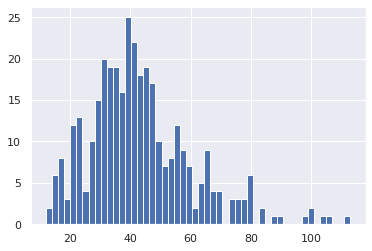

In [26]:
plt.hist([len(s) for s in sentences_train], bins = 50)
plt.plot()

In [27]:
maxlen_train = 344

X_train = [[word2idx_train[w[0]] for w in s] for s in sentences_train]
X_train = pad_sequences(maxlen = maxlen_train, sequences = X_train, padding = "post",value = n_words_train - 1)

Y_train = [[tag2idx_train[w[1]] for w in s] for s in sentences_train]
Y_train = pad_sequences(maxlen = maxlen_train, sequences = Y_train, padding = "post", value = 6)
Y_train = [to_categorical(i, num_classes = n_tags_train) for i in Y_train]

In [28]:
X_train

array([[ 9160,     1, 10563, ..., 15170, 15170, 15170],
       [15031, 10266, 13214, ..., 15170, 15170, 15170],
       [ 9450,   197,  6274, ..., 15170, 15170, 15170],
       ...,
       [15089, 15090, 15091, ..., 15170, 15170, 15170],
       [15152, 15151, 15135, ..., 15170, 15170, 15170],
       [15155, 15156, 15157, ..., 15170, 15170, 15170]], dtype=int32)

In [29]:
X_train.shape

(350, 344)

In [30]:
Y_train

[array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32),
 array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32),
 array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],


In [31]:
y = np.array(Y_train).shape

In [32]:
n_words_train

15171

In [33]:
!pip install livelossplot

In [34]:
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

In [35]:
input = Input(shape=(344,))
word_embedding_size = 210

# Embedding Layer
model = Embedding(input_dim = n_words_train, output_dim = word_embedding_size, input_length = 344)(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units = word_embedding_size,activation = "tanh", recurrent_activation =  "sigmoid", 
                           use_bias = True, kernel_initializer = k.initializers.he_normal(),
                           recurrent_initializer = "orthogonal", bias_initializer = "zeros", return_sequences = True,
                           recurrent_dropout = 0.5, dropout = 0.5))(model)

model = LSTM(units = word_embedding_size * 2, activation = "tanh", recurrent_activation =  "sigmoid", 
                           use_bias = True, kernel_initializer = k.initializers.he_normal(),
                           recurrent_initializer = "orthogonal", bias_initializer = "zeros", return_sequences = True,
                           recurrent_dropout = 0.5, dropout = 0.5)(model)

                           


# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags_train, activation = "relu"))(model)     #use_bias

# CRF Layer
crf = CRF(n_tags_train)

out = crf(model)  # output
print("----------------------")
print(out)
print("----------------------")
model = Model(input, out)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
----------------------
Tensor("crf_1/cond/Merge:0", shape=(?, 344, 7), dtype=float32)
----------------------


In [36]:
X_train.shape

(350, 344)

In [37]:
np.array(Y_train)

array([[[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       ...,

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0.

In [38]:
#Optimiser 
adam = k.optimizers.Adam(learning_rate = 0.0005, beta_1 = 0.9, beta_2 = 0.999)

# Compile model
model.compile(optimizer = adam, loss = crf.loss_function,sample_weight_mode = None , 
              metrics = [crf.accuracy, 'accuracy'], target_tensors = None)

model.summary()

# Saving the best model only
file_path = "TA-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(file_path, period = 1, monitor = 'val_accuracy', verbose = 1, save_best_only = True, 
                             save_weights_only = False, mode = "max")     #max --> auto
callbacks_list = [checkpoint]


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 344)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 344, 210)          3185910   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 344, 420)          707280    
_________________________________________________________________
lstm_2 (LSTM)                (None, 344, 420)          1412880   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 344, 7)            2947      
_________________________________________________________________
crf_1 (CRF)                  (None, 344, 7)            119       
Total params: 5,309,136
Trainab

In [39]:
# Fit the best model
model_fitting = model.fit(X_train, np.array(Y_train), batch_size = 256, epochs = 4, validation_split = 0.2, verbose = 1, 
                    callbacks = callbacks_list, shuffle = True, initial_epoch = 0, max_queue_size = 10)


Train on 280 samples, validate on 70 samples
Epoch 1/4
280/280 [==============================] - 54s 191ms/step - loss: 2.2600 - crf_viterbi_accuracy: 0.1215 - accuracy: 0.0202 - val_loss: 1.5396 - val_crf_viterbi_accuracy: 0.4508 - val_accuracy: 0.4508

Epoch 00001: val_accuracy improved from -inf to 0.45079, saving model to TA-0.45.hdf5
Epoch 2/4
280/280 [==============================] - 45s 162ms/step - loss: 1.6571 - crf_viterbi_accuracy: 0.5610 - accuracy: 0.0202 - val_loss: 0.6809 - val_crf_viterbi_accuracy: 0.9077 - val_accuracy: 0.9077

Epoch 00002: val_accuracy improved from 0.45079 to 0.90772, saving model to TA-0.91.hdf5
Epoch 3/4
280/280 [==============================] - 44s 158ms/step - loss: 0.9421 - crf_viterbi_accuracy: 0.8743 - accuracy: 0.0202 - val_loss: 0.2845 - val_crf_viterbi_accuracy: 0.9168 - val_accuracy: 0.9168

Epoch 00003: val_accuracy improved from 0.90772 to 0.91682, saving model to TA-0.92.hdf5
Epoch 4/4
280/280 [==============================] - 45s 

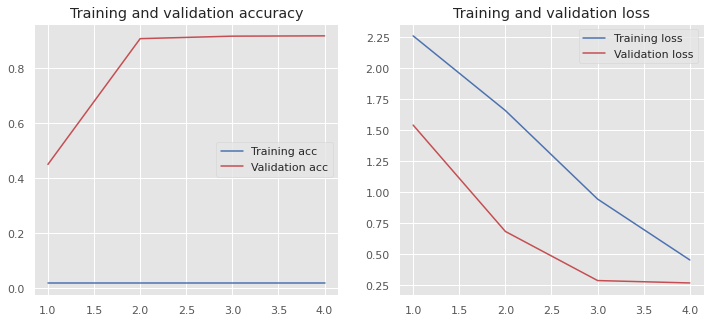

In [40]:
plt.style.use('ggplot')

def plot_history(history):
    accuracy_train = history.history['accuracy']
    validation_accuracy_train = history.history['val_accuracy']
    loss_train = history.history['loss']
    validation_loss_train = history.history['val_loss']
    x = range(1, len(accuracy_train) + 1)

    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy_train, 'b', label = 'Training acc')
    plt.plot(x, validation_accuracy_train, 'r', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss_train, 'b', label = 'Training loss')
    plt.plot(x, validation_loss_train, 'r', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(model_fitting)

In [41]:
test = [j for i in test_docs for j in i]

In [42]:
r = []
for i in range(len(test_docs)):
    x = len(test_docs[i])
    for j in range(x):
        r.append(i+1)

In [43]:
dataset_test = pd.DataFrame(test, columns = ["Words", "Tags"])

In [44]:
dataset_test["Sentence_idx"] = r

In [45]:
dataset_test.info()
dataset_test.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21133 entries, 0 to 21132
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Words         21133 non-null  object
 1   Tags          21133 non-null  object
 2   Sentence_idx  21133 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 495.4+ KB


,Words,Tags,Sentence_idx
16094,of,O,78
13464,adiabatically,O,66
1642,compared,O,8
11395,energy,O,56
13189,the,O,65


In [46]:
words_test = list(set(dataset_test["Words"].values))
n_words_test = len(words_test)

tags_test = []
for tag_test in set(dataset_test["Tags"].values):
  if tag_test is nan or isinstance(tag_test, float):
    tags_test.append("Unknown")
  else:
    tags_test.append(tag_test)

n_tags_test  = len(tags_test)

In [47]:
getter = make_sentence(dataset_test)
sentences_test = getter.sentences

In [48]:
word2idx_test = {w: i for i, w in enumerate(words_test)}

tag2idx_test = tag2idx_train

#tag2idx_test = {t: i for i, t in enumerate(tags_test)}
idx2tag_test = {v: k for k, v in iteritems(tag2idx_test)}

In [49]:
maxlen_test = 344

X_test = [[word2idx_test[w[0]] for w in s] for s in sentences_test]
X_test = pad_sequences(maxlen = maxlen_test, sequences = X_test, padding = "post",value = n_words_test - 1)

Y_test = [[tag2idx_test[w[1]] for w in s] for s in sentences_test]
Y_test = pad_sequences(maxlen = maxlen_test, sequences = Y_test, padding = "post", value = 6)
Y_test = [to_categorical(i, num_classes = n_tags_test) for i in Y_test]

In [50]:
def prediction(pred):
  output = []
  for i in pred:
    output_i = []
    for p in i:
      i = np.argmax(p)
      output_i.append(idx2tag_test[i])
    output.append(output_i)
  return output

pred_test = model.predict(X_test, verbose = 1)
labels_pred = prediction(pred_test)
labels_test = prediction(Y_test)

100/100 [==============================] - 6s 63ms/step


In [51]:
print("F1-score: {:.1}".format(f1_score(labels_test, labels_pred)))

F1-score: 0.5
